In [1]:
import torch

data_path = "/kaggle/input/cinic10/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [2]:
from torch import nn

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(
            self,
            conv_layers,
            fc_layers,
            conv_activation = nn.ReLU(),
            use_conv_normalisation = True,
            use_conv_maxpool = True,
            fc_activation = nn.ReLU(),
            use_fc_dropout = 0,
            n_classes = 10,
            n_channels = 3):
        """
            Custom CNN model supporting easy architecture and hyperparams adjustments.
            
            Args:
                conv_layers (List<Tuple>). 
                    Each tuple contains (num_filters (int), kernel_size(int), ) for conv layers.
                fc_layers (List<int>): List of fully connected layer sizes.
                conv_activation (nn.Module): Activation function for convolutional layers. Default: ReLU.
                use_conv_normalisation (bool): Whether to apply batch normalisation after conv layers. Default: True.
                use_conv_maxpool (bool): Whether to apply max pooling after conv layers. Default: True.
                fc_activation (nn.Module): Activation function for fully connected layers. Default: ReLU.
                use_fc_dropout (float): Dropout rate for fully connected layers. Default: 0.
                n_classes (int): Number of output classes. Default: 10.
                n_channels (int): Number of input channels (3 for RGB, 1 for grayscale). Default: 3.
        """
        super().__init__()
        
        self.convolutional_layers = self._create_conv_layers(
            n_channels,
            conv_layers,
            conv_activation,
            use_conv_normalisation,
            use_conv_maxpool)
        
        self.flatten_dim = self._calculate_flatten_dim(32, conv_layers, use_conv_maxpool)
        
        self.fc_layers = self._create_fc_layers(
            self.flatten_dim,
            fc_layers,
            fc_activation,
            use_fc_dropout,
            n_classes)
        
    def forward(self, x):
        for layer in self.convolutional_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        for layer in self.fc_layers:
            x = layer(x)
        return x
     
    def _create_conv_layers(self, input_channels, conv_layers, conv_activation, conv_normalisation, conv_maxpool):
        layers = nn.ModuleList()
        in_channels = input_channels

        for out_channels, kernel_size in conv_layers:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size))
            if(conv_normalisation):
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(conv_activation)
            if(conv_maxpool):
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
            in_channels = out_channels
            
        return layers
    
    def _create_fc_layers(self, input_size, fc_layers, fc_activation, fc_dropout, n_classes):
        layers = nn.ModuleList()
        fc_input_size = input_size
        
        for fc_size in fc_layers:
            layers.append(nn.Linear(fc_input_size, fc_size))
            layers.append(fc_activation)
            if(fc_dropout > 0):
                layers.append(nn.Dropout(fc_dropout))
                
            fc_input_size = fc_size
            
        layers.append(nn.Linear(fc_input_size, n_classes)) # Output layer
        return layers
    
    def _calculate_flatten_dim(self, input_size, conv_layers, use_maxpool):
        # Start with the initial number of channels and input size
        feature_map_size = input_size
        current_channels = None
        for out_channels, kernel_size in conv_layers:
            # Reduce spatial dimensions by the convolution (assuming no padding)
            feature_map_size = feature_map_size - (kernel_size - 1)
            # Apply max pooling if enabled
            if use_maxpool:
                feature_map_size //= 2
            current_channels = out_channels  # Update to current out_channels
            
        return feature_map_size ** 2 * current_channels

In [3]:
def preload_to_gpu(data_loader, device):
    all_images = []
    all_labels = []
    
    for images, labels in data_loader:
        all_images.append(images)
        all_labels.append(labels)

    images_tensor = torch.cat(all_images).to(device)
    labels_tensor = torch.cat(all_labels).to(device)

    return images_tensor, labels_tensor

In [4]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import multiprocessing

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

print("Starting data loading. It may take a few minutes.")
train_dataset = ImageFolder(root=f"{data_path}/train", transform=transform)
print("Train set loaded...")

val_dataset = ImageFolder(root=f"{data_path}/valid", transform=transform)
print("Validation set loaded...")

test_dataset = ImageFolder(root=f"{data_path}/test", transform=transform)
print("Test set loaded...")

batch_size = 64
num_workers = max(2, multiprocessing.cpu_count() - 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True,
                        persistent_workers=True, prefetch_factor=4)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True,
                         persistent_workers=True, prefetch_factor=4)



#train_images, train_labels = preload_to_gpu(train_loader, device)
#val_images, val_labels = preload_to_gpu(val_loader, device)
#test_images, test_labels = preload_to_gpu(test_loader, device)
#print("Data loaded to GPU successfully.")

Starting data loading. It may take a few minutes.
Train set loaded...
Validation set loaded...
Test set loaded...


In [19]:
import torch
import torch.nn as nn

conv_layers = [(32, 3), (64, 3), (128, 3)]
fc_layers = [256, 128]

model = ConvolutionalNeuralNetwork(
    conv_layers=conv_layers,
    fc_layers=fc_layers,
    conv_activation=nn.ReLU(),
    use_conv_normalisation=True,
    use_conv_maxpool=True,
    fc_activation=nn.ReLU(),
    use_fc_dropout=0.25,
    n_classes=10,
    n_channels=3
)

model.to(device)

ConvolutionalNeuralNetwork(
  (convolutional_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_f

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device="cuda"):
    """
    Trains a CNN model using DataLoaders for training and validation.

    Args:
        model (nn.Module): The CNN model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        model (nn.Module): The trained model.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Training starting...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        # Training loop using the train_loader
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)  # Sum loss for the batch
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = 100 * correct / total
        
        # Validation loop using the val_loader
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / total_val
        val_acc = 100 * correct_val / total_val
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    print("Training complete.")
    return model

def evaluate_model(model, test_loader, criterion, device="cuda"):
    """
    Evaluates the model on test data using a DataLoader.

    Args:
        model (nn.Module): The CNN model.
        test_loader (DataLoader): DataLoader for test data.
        criterion (Loss Function): Loss function for evaluation.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        None. Prints out the test loss and accuracy.
    """
    model.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_loss = test_loss / total_test
    test_acc = 100 * correct_test / total_test
    return test_loss, test_acc

In [20]:
trained_model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.005, device=device)

Training starting...
Epoch [1/20], Train Loss: 1.6063, Train Acc: 40.41%, Val Loss: 1.3774, Val Acc: 50.05%
Epoch [2/20], Train Loss: 1.3687, Train Acc: 50.99%, Val Loss: 1.3149, Val Acc: 53.07%
Epoch [3/20], Train Loss: 1.2681, Train Acc: 55.18%, Val Loss: 1.2200, Val Acc: 56.13%
Epoch [4/20], Train Loss: 1.2012, Train Acc: 57.80%, Val Loss: 1.1662, Val Acc: 58.76%
Epoch [5/20], Train Loss: 1.1570, Train Acc: 59.63%, Val Loss: 1.1410, Val Acc: 59.53%
Epoch [6/20], Train Loss: 1.1177, Train Acc: 60.94%, Val Loss: 1.1553, Val Acc: 59.24%
Epoch [7/20], Train Loss: 1.0831, Train Acc: 62.39%, Val Loss: 1.1563, Val Acc: 60.25%
Epoch [8/20], Train Loss: 1.0535, Train Acc: 63.42%, Val Loss: 1.1220, Val Acc: 61.09%
Epoch [9/20], Train Loss: 1.0316, Train Acc: 64.25%, Val Loss: 1.0886, Val Acc: 62.31%
Epoch [10/20], Train Loss: 1.0093, Train Acc: 65.01%, Val Loss: 1.1025, Val Acc: 61.71%
Epoch [11/20], Train Loss: 0.9877, Train Acc: 65.90%, Val Loss: 1.1070, Val Acc: 61.90%
Epoch [12/20], Train

In [22]:
test_loss, test_accuracy = evaluate_model(trained_model, test_loader, nn.CrossEntropyLoss(), device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.1238, Test Accuracy: 61.77%


In [23]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_confusion_matrix(model, test_loader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Obliczenie macierzy pomyłek
    cm = confusion_matrix(all_labels, all_preds)
    
    # Wypisanie macierzy
    print("Confusion Matrix:")
    print(cm)
    
    # Opcjonalnie: wizualizacja macierzy pomyłek przy użyciu heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predictions")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return cm


Confusion Matrix:
[[6693   95  411   59   98  139   29  227  982  267]
 [ 291 5549   90   72   40  165   41  160  697 1895]
 [ 587   32 5400  551  675  727  338  238  389   63]
 [  90   46  848 3638  838 2579  312  335  193  121]
 [ 162   28  759  633 4749  924  116 1285  249   95]
 [ 103   60  721  961 1046 4731  135  921  201  121]
 [  58   34 1425 1426  383  303 5157   59  122   33]
 [ 121   38  266  135  531  890   39 6697  129  154]
 [ 728  139  326  153  128  207   74  199 6705  341]
 [ 323 1029   89   65   54  203   31  238  691 6277]]


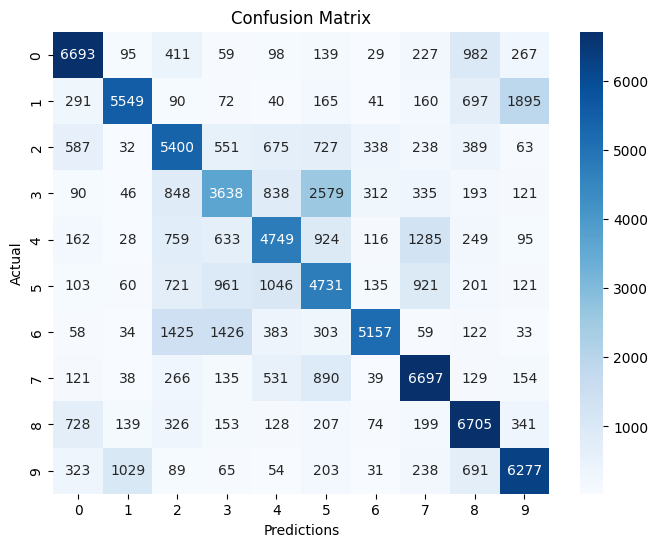

In [25]:
cm = evaluate_confusion_matrix(model, test_loader, device="cuda")